In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter as fsf
from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, negative_log, load_style_sheet
import numpy as np
import vice
import sys
sys.path.append("..")
from src.utils import subsample_stellar_populations, get_velocity_profile, get_velocity_evolution, oh_to_12pluslog
from src.plots.utils import weighted_median
load_style_sheet("papers")
print(sys.version_info)

/Users/jamesjohnson/Work/Research/lib/public-dev/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)


In [7]:
outputs = [
    "../outputs/expifr_gse/amd/tacc3p2/massratio3/expsigma/gsebetaphiin-0p8",
    # "../outputs/expifr_gse/amd/tacc3p2/massratio3/expsigma/gsebetaphiin-0p8-rscale3",
    "../outputs/expifr_gse/amd/tacc3p2/massratio3/expsigma/gsebetaphiin-0p8-rscale4",
    "../outputs/expifr_gse/amd/tacc3p2/massratio3/expsigma/gsebetaphiin-0p8-rscale6"
    # "../outputs/expifr_gse/amd/tacc3p2/massratio3/constsigma/gsebetaphiin-0p8"
]
outputs = [vice.output(name) for name in outputs]
for out in outputs:
    extra = np.genfromtxt("%s_analogdata.out" % (out.name))
    out.stars["absz"] = [abs(_) for _ in extra[:,-1][:out.stars.size[0]]]

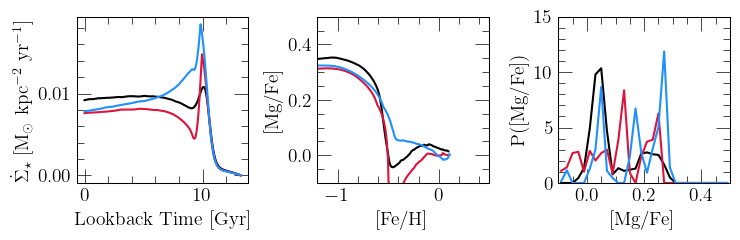

In [11]:
COLORS = ["black", "crimson", "dodgerblue"]
# COLORS = ["crimson", "dodgerblue"]
LABELS = ["Fiducial", r"$r_\text{GSE} = 4$ kpc", r"$r_\text{GSE} = 6$ kpc"]
FEH_MIN = -0.4
FEH_MAX = -0.2

fig = plt.figure(figsize = (7.5, 2.5))
axes = []
for i in range(3):
    axes.append(fig.add_subplot(131 + i))
axes[0].set_xlabel(r"Lookback Time [Gyr]")
axes[0].set_ylabel(r"$\dot \Sigma_\star$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
axes[1].set_xlabel(r"[Fe/H]")
axes[1].set_ylabel(r"[Mg/Fe]")
axes[2].set_xlabel(r"[Mg/Fe]")
axes[2].set_ylabel(r"P([Mg/Fe])")
axes[1].set_xlim([-1.2, 0.5])
axes[1].set_ylim([-0.1, 0.5])
axes[2].set_xlim([-0.1, 0.5])
axes[2].set_ylim([0, 15])
axes[2].set_xticks([0, 0.2, 0.4])

def plot_sfh(ax, output, radius = 8, zone_width = 0.1, **kwargs):
    zone = int(radius / zone_width)
    zone = output.zones["zone%d" % (zone)]
    area = np.pi * ((radius + zone_width)**2 - radius**2)
    sfh = [s / area for s in zone.history["sfr"]]
    ax.plot(zone.history["lookback"], sfh, **kwargs)

def plot_track(ax, output, radius = 8, zone_width = 0.1, **kwargs):
    zone = int(radius / zone_width)
    zone = output.zones["zone%d" % (zone)]
    ax.plot(zone.history["[fe/h]"], zone.history["[mg/fe]"], **kwargs)

def plot_distributions(ax, output, rmin, rmax, abszmin, abszmax, fehmin, fehmax, zone_width = 0.1, **kwargs):
    stars = output.stars.filter(
        "zone_final", ">=", int(rmin / zone_width)).filter(
        "zone_final", "<=", int(rmax / zone_width) - 1).filter(
        "absz", ">=", abszmin).filter(
        "absz", "<=", abszmax).filter(
        "[fe/h]", ">=", fehmin).filter(
        "[fe/h]", "<=", fehmax).filter(
        "mass", ">=", 1)
    hist, bins = np.histogram(stars["[mg/fe]"], bins = 30, range = ax.get_xlim(),
        weights = stars["mass"], density = True)
    xvals = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
    ax.plot(xvals, hist, **kwargs)

for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "label": LABELS[i]
    }
    if i in [1, 2]: kwargs["zone_width"] = 1
    plot_sfh(axes[0], outputs[i], **kwargs)
    plot_track(axes[1], outputs[i], **kwargs)
    plot_distributions(axes[2], outputs[i], 7, 9, 0, 0.5, FEH_MIN, FEH_MAX, **kwargs)

plt.tight_layout()
plt.show()